<a href="https://colab.research.google.com/github/CarolKSD/Weather_Data_Clusterization/blob/main/HistoricalWeatherDataClusterization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import folium

In [2]:
# Load the dataset
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/daily_weather_data.csv')

# Display the first rows of the dataset
print("Initial data preview:")
print(data.head())
print("\nDataset information:")
print(data.info())

Mounted at /content/drive
Initial data preview:
         date   country     city   Latitude  Longitude  tavg  tmin  tmax  \
0  21-07-2018  Abkhazia  Sukhumi  43.001525  41.023415  23.4  20.9  25.5   
1  22-07-2018  Abkhazia  Sukhumi  43.001525  41.023415  23.5  21.0  25.7   
2  23-07-2018  Abkhazia  Sukhumi  43.001525  41.023415  23.5  21.1  25.5   
3  24-07-2018  Abkhazia  Sukhumi  43.001525  41.023415  24.3  20.8  27.1   
4  25-07-2018  Abkhazia  Sukhumi  43.001525  41.023415  26.5  22.7  30.0   

    wdir  wspd    pres  
0  329.0   9.3  1009.6  
1  337.0   9.4  1010.0  
2   41.0   8.2  1007.7  
3   10.0   9.3  1004.4  
4    9.0   9.7  1002.0  

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324647 entries, 0 to 324646
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   date       324647 non-null  object 
 1   country    324647 non-null  object 
 2   city       324647 non-null  object 
 3   La

In [3]:
# Rename columns for better readability
data.rename(columns={
    'date': 'Date',
    'country': 'Country',
    'city': 'City',
    'tavg': 'Avg Temperature (°C)',
    'tmin': 'Min Temperature (°C)',
    'tmax': 'Max Temperature (°C)',
    'wdir': 'Wind Direction (°)',
    'wspd': 'Wind Speed (m/s)',
    'pres': 'Pressure (hPa)'

}, inplace=True)

# Set Date, Country, and City as the multi-index
data.set_index(['Date', 'Country', 'City'], inplace=True)

In [4]:
data.head()

,,,Latitude,Longitude,Avg Temperature (°C),Min Temperature (°C),Max Temperature (°C),Wind Direction (°),Wind Speed (m/s),Pressure (hPa)
Date,Country,City,,,,,,,,
21-07-2018,Abkhazia,Sukhumi,43.001525,41.023415,23.4,20.9,25.5,329.0,9.3,1009.6
22-07-2018,Abkhazia,Sukhumi,43.001525,41.023415,23.5,21.0,25.7,337.0,9.4,1010.0
23-07-2018,Abkhazia,Sukhumi,43.001525,41.023415,23.5,21.1,25.5,41.0,8.2,1007.7
24-07-2018,Abkhazia,Sukhumi,43.001525,41.023415,24.3,20.8,27.1,10.0,9.3,1004.4
25-07-2018,Abkhazia,Sukhumi,43.001525,41.023415,26.5,22.7,30.0,9.0,9.7,1002.0


In [5]:
# ------------------------------
# 1. EXPLORATORY DATA ANALYSIS (EDA)
# ------------------------------

# Describe basic statistics of the dataset
print("\nDescriptive statistics:")
data.describe()


Descriptive statistics:


,Latitude,Longitude,Avg Temperature (°C),Min Temperature (°C),Max Temperature (°C),Wind Direction (°),Wind Speed (m/s),Pressure (hPa)
count,324647.000000,324647.000000,314963.000000,312284.000000,312269.000000,283937.000000,302400.000000,289416.000000
mean,19.557777,13.989870,21.023282,17.395555,25.042591,163.814931,13.320338,1013.275333
std,26.076725,76.541269,9.309077,9.384259,9.769574,101.923106,7.309672,7.166760
min,-54.430000,-176.176447,-33.800000,-39.300000,-27.300000,0.000000,0.000000,860.200000
25%,4.922420,-51.694138,15.600000,11.300000,19.800000,81.000000,8.100000,1009.900000
50%,18.067519,13.289437,25.000000,21.300000,28.600000,142.000000,11.600000,1012.900000
75%,41.902179,51.531040,27.500000,24.500000,31.200000,251.000000,16.900000,1016.800000
max,78.062000,179.198128,44.100000,38.500000,89.600000,360.000000,105.500000,1058.000000


In [6]:
# Check for missing values
print("\nMissing values in each column:")
print(data.isnull().sum())


Missing values in each column:
Latitude                    0
Longitude                   0
Avg Temperature (°C)     9684
Min Temperature (°C)    12363
Max Temperature (°C)    12378
Wind Direction (°)      40710
Wind Speed (m/s)        22247
Pressure (hPa)          35231
dtype: int64


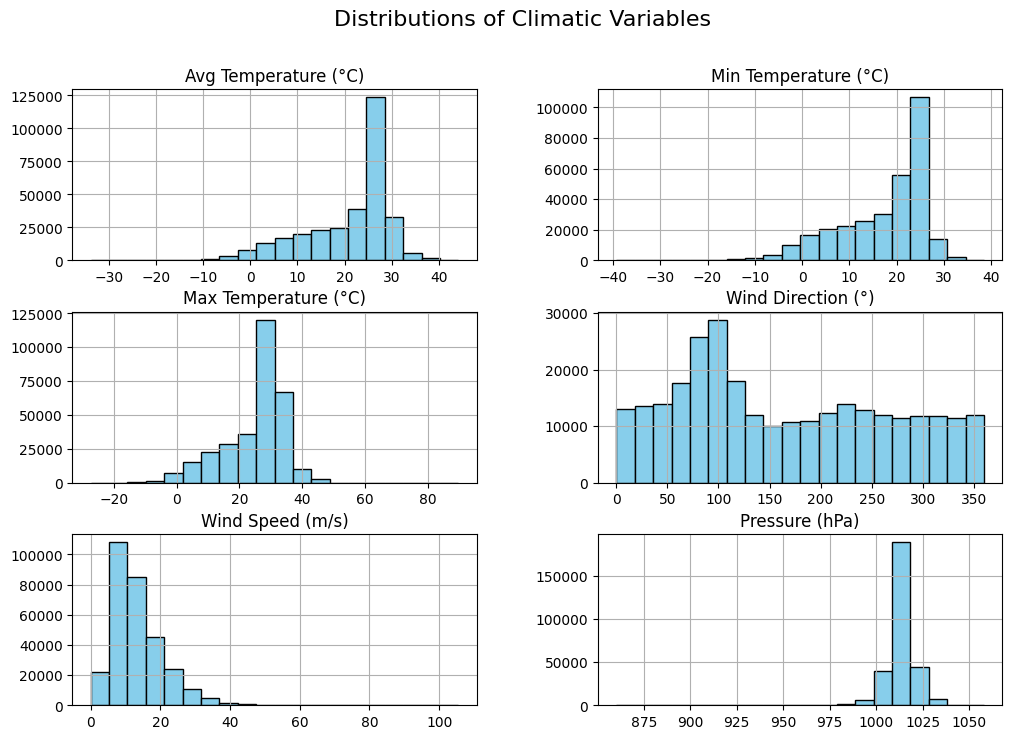

In [7]:
# Plot distributions of numerical features
numeric_features = ['Avg Temperature (°C)', 'Min Temperature (°C)', 'Max Temperature (°C)',
                    'Wind Direction (°)', 'Wind Speed (m/s)', 'Pressure (hPa)', ]
data[numeric_features].hist(figsize=(12, 8), bins=20, color='skyblue', edgecolor='black')
plt.suptitle("Distributions of Climatic Variables", fontsize=16)
plt.show()

In [8]:
# Identify city and country with the highest and lowest temperatures

# Highest average temperature
max_temp_row = data.loc[data['Avg Temperature (°C)'].idxmax()]
print("\nCity and country with the highest average temperature:")
print(f"Date: {max_temp_row.name[0]}, Country: {max_temp_row.name[1]}, City: {max_temp_row.name[2]}")
print(f"Avg Temperature: {max_temp_row['Avg Temperature (°C)']} °C")

# Lowest average temperature
min_temp_row = data.loc[data['Avg Temperature (°C)'].idxmin()]
print("\nCity and country with the lowest average temperature:")
print(f"Date: {min_temp_row.name[0]}, Country: {min_temp_row.name[1]}, City: {min_temp_row.name[2]}")
print(f"Avg Temperature: {min_temp_row['Avg Temperature (°C)']} °C")


City and country with the highest average temperature:
Date: 31-07-2020, Country: Kuwait, City: Kuwait City
Avg Temperature: 44.1 °C

City and country with the lowest average temperature:
Date: 22-01-2018, Country: Kazakhstan, City: Astana
Avg Temperature: -33.8 °C


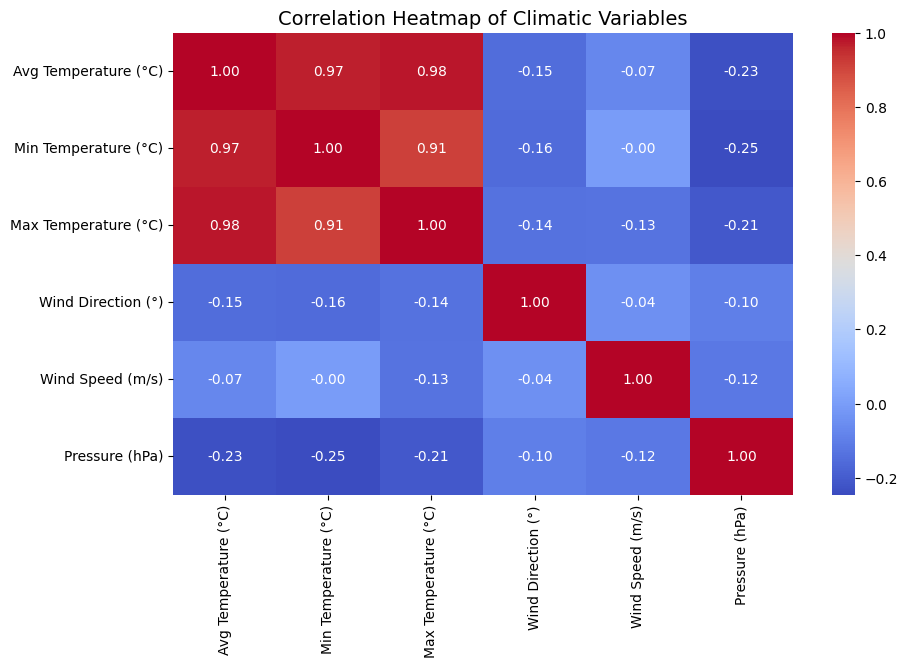

In [9]:
# Correlation analysis
plt.figure(figsize=(10, 6))
sns.heatmap(data[numeric_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Climatic Variables", fontsize=14)
plt.show()

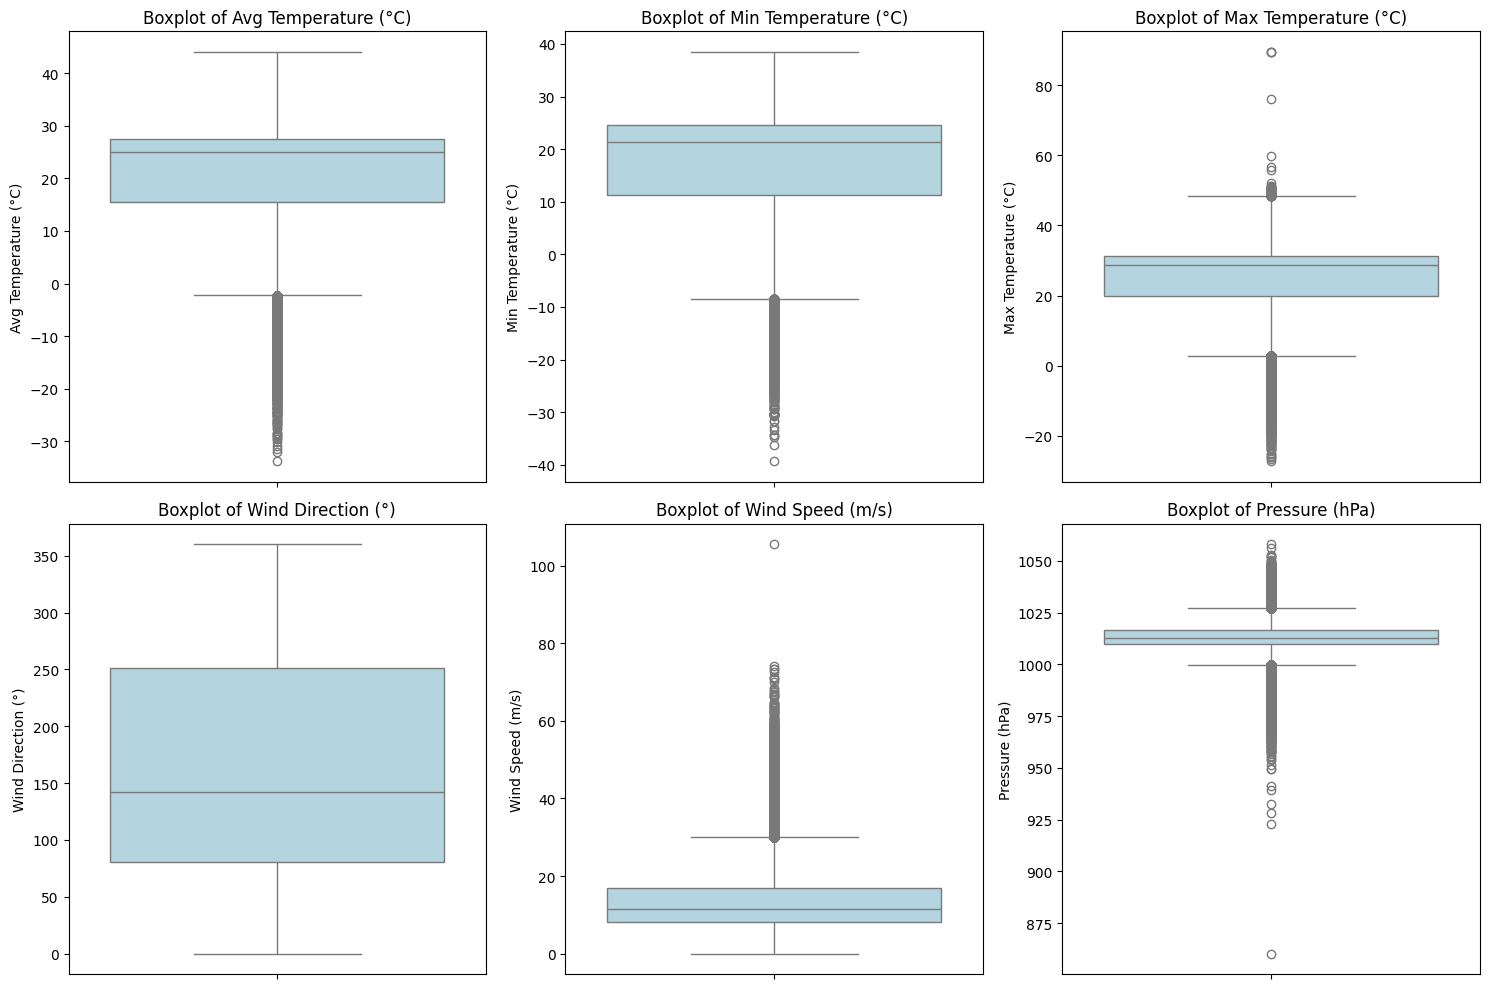

In [10]:
# Calculate number of rows and columns for subplots
num_features = len(numeric_features)
num_cols = 3
num_rows = (num_features // num_cols) + (num_features % num_cols > 0)

# Plot boxplots for outlier detection
plt.figure(figsize=(15, 5 * num_rows))
for i, feature in enumerate(numeric_features):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(data[feature], color='lightblue')
    plt.title(f"Boxplot of {feature}")
plt.tight_layout()
plt.show()

In [11]:
# ------------------------------
# 2. DATA CLEANING
# ------------------------------

# Replace missing values with the mean of each column
data.fillna(data.mean(), inplace=True)
print("\nData after handling missing values:")
print(data.isnull().sum())


Data after handling missing values:
Latitude                0
Longitude               0
Avg Temperature (°C)    0
Min Temperature (°C)    0
Max Temperature (°C)    0
Wind Direction (°)      0
Wind Speed (m/s)        0
Pressure (hPa)          0
dtype: int64


In [12]:
# ------------------------------
# 3. FEATURE ENGINEERING: WIND COMPONENTS
# ------------------------------

# Calculate U and V components from wind speed and direction
data['U Component'] = data['Wind Speed (m/s)'] * np.cos(np.radians(data['Wind Direction (°)']))
data['V Component'] = data['Wind Speed (m/s)'] * np.sin(np.radians(data['Wind Direction (°)']))

In [13]:
# ------------------------------
# 4. NORMALIZATION
# ------------------------------

# Select columns for clustering
features = ['Avg Temperature (°C)', 'Min Temperature (°C)', 'Max Temperature (°C)',
            'Wind Speed (m/s)', 'Pressure (hPa)', 'U Component', 'V Component']
climate_data = data[features]

# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(climate_data)

print("\nFirst rows of normalized data:")
print(pd.DataFrame(scaled_data, columns=features).head())



First rows of normalized data:
   Avg Temperature (°C)  Min Temperature (°C)  Max Temperature (°C)  \
0              0.259208              0.380759              0.047739   
1              0.270114              0.391625              0.068612   
2              0.270114              0.402490              0.047739   
3              0.357363              0.369894              0.214727   
4              0.597297              0.576330              0.517394   

   Wind Speed (m/s)  Pressure (hPa)  U Component  V Component  
0         -0.569876       -0.543149     0.957497    -0.664115  
1         -0.555701       -0.484036     1.027040    -0.563284  
2         -0.725799       -0.823935     0.775439     0.253898  
3         -0.569876       -1.311617     1.078702    -0.085950  
4         -0.513177       -1.666294     1.121777    -0.094752  


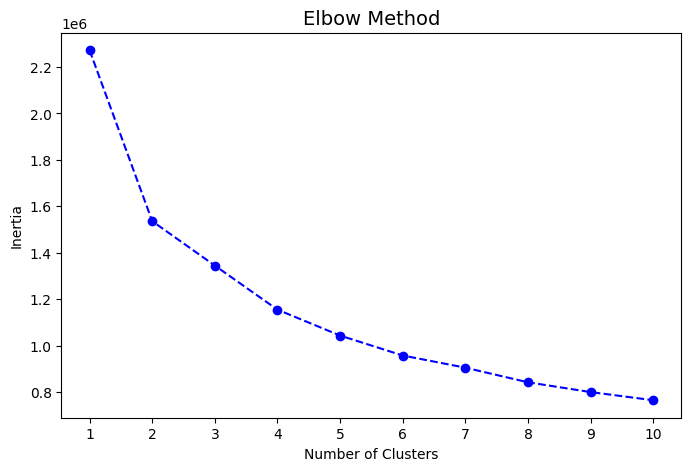

In [14]:
# ------------------------------
# 5. FINDING THE OPTIMAL NUMBER OF CLUSTERS (Elbow Method)
# ------------------------------

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--', color='b')
plt.title("Elbow Method", fontsize=14)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.xticks(range(1, 11))
plt.show()

In [15]:
# ------------------------------
# 6. APPLYING K-MEANS
# ------------------------------

# Choose the number of clusters based on the Elbow Method
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data['Cluster'] = kmeans.fit_predict(scaled_data)

# Display the first results
print("\nData with assigned clusters:")
print(data[['Cluster']])


Data with assigned clusters:
                                    Cluster
Date       Country        City             
21-07-2018 Abkhazia       Sukhumi         0
22-07-2018 Abkhazia       Sukhumi         0
23-07-2018 Abkhazia       Sukhumi         0
24-07-2018 Abkhazia       Sukhumi         0
25-07-2018 Abkhazia       Sukhumi         0
...                                     ...
07-10-2022 Western Sahara El Aaiún        0
08-10-2022 Western Sahara El Aaiún        0
09-10-2022 Western Sahara El Aaiún        2
10-10-2022 Western Sahara El Aaiún        2
11-10-2022 Western Sahara El Aaiún        2

[324647 rows x 1 columns]


In [16]:
from sklearn.metrics import calinski_harabasz_score

score = calinski_harabasz_score(scaled_data, data['Cluster'])
print(f"Calinski-Harabasz Index: {score}")

Calinski-Harabasz Index: 112003.19025652975


In [18]:
# ------------------------------
# 7. SAVE RESULTS
# ------------------------------

# Save the updated data to a new CSV file
data.to_csv('clustered_weather_data.csv', index=False)
print("\nResults saved as 'clustered_weather_data.csv'!")


Results saved as 'clustered_weather_data.csv'!



Cluster summary:
         Avg Temperature (°C)  Min Temperature (°C)  Max Temperature (°C)  \
Cluster                                                                     
0                   26.290418             22.228914             30.936379   
1                    8.104992              4.706152             11.916772   
2                   24.903410             21.737646             28.140103   

         Wind Speed (m/s)  Pressure (hPa)  U Component  V Component  
Cluster                                                              
0                9.820604     1011.428524     0.272466    -0.553719  
1               13.924979     1015.404117    -0.284383    -3.297597  
2               18.209939     1014.161792    -5.071688    12.920792  


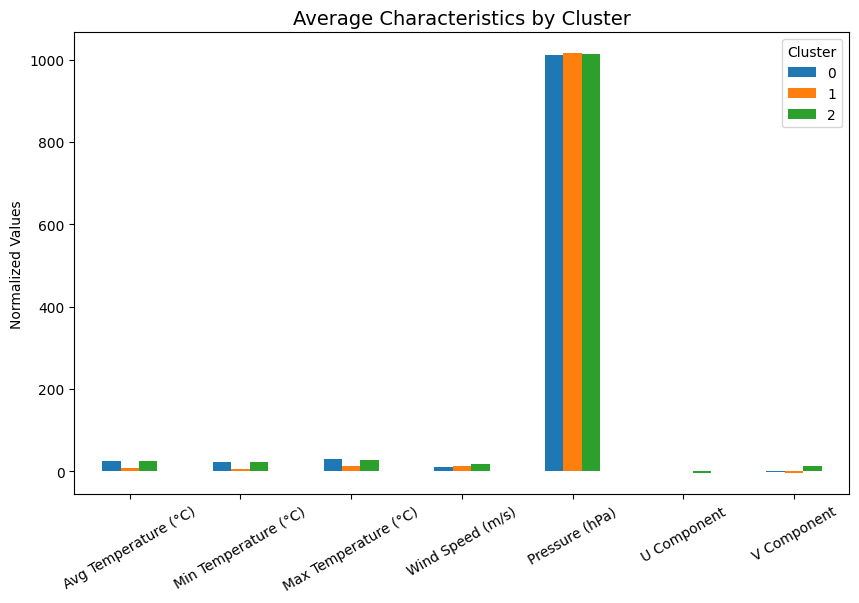

In [19]:
# ------------------------------
# 8. CLUSTER ANALYSIS
# ------------------------------

# Statistical summary by cluster
cluster_summary = data.groupby('Cluster')[features].mean()
print("\nCluster summary:")
print(cluster_summary)

# Plot average characteristics of each cluster
cluster_summary.T.plot(kind='bar', figsize=(10, 6))
plt.title("Average Characteristics by Cluster", fontsize=14)
plt.ylabel("Normalized Values")
plt.xticks(rotation=30)
plt.show()

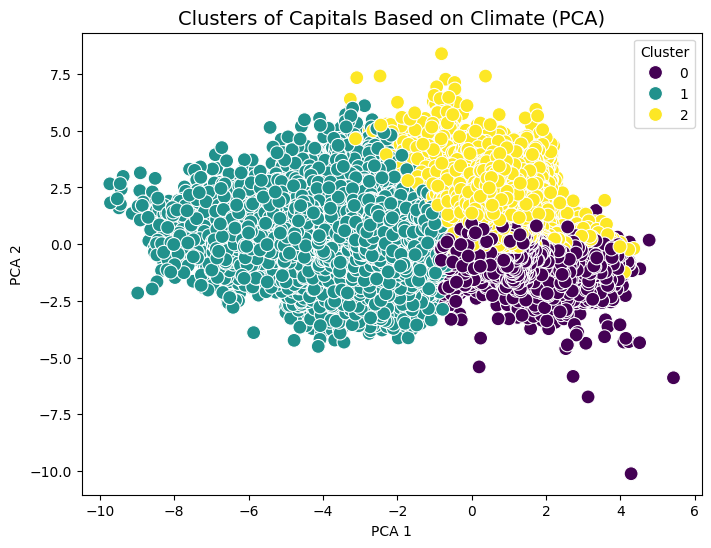

In [20]:
# ------------------------------
# 9. VISUALIZATION IN 2D USING PCA
# ------------------------------

# Reduce the data to 2 dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

# Create a DataFrame with the principal components
reduced_df = pd.DataFrame(reduced_data, columns=['PCA1', 'PCA2'], index=data.index)
reduced_df['Cluster'] = data['Cluster']

# Plot the clusters in 2D
plt.figure(figsize=(8, 6))
sns.scatterplot(data=reduced_df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=100)
plt.title("Clusters of Capitals Based on Climate (PCA)", fontsize=14)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.show()

In [21]:
# Group by cluster and count countries and cities
cluster_summary = data.reset_index().groupby('Cluster')[['Country', 'City']].agg(['unique', 'count'])

# Display the summary
print("Summary of Countries and Cities in Each Cluster:")
print(cluster_summary)

Summary of Countries and Cities in Each Cluster:
                                                   Country          \
                                                    unique   count   
Cluster                                                              
0        [Abkhazia, Aland Islands, Albania, Algeria, Am...  144808   
1        [Abkhazia, Aland Islands, Albania, Algeria, Ar...   86944   
2        [Abkhazia, Aland Islands, Albania, Algeria, Am...   92895   

                                                      City          
                                                    unique   count  
Cluster                                                             
0        [Sukhumi, Mariehamn, Tirana, Algiers, Pago Pag...  144808  
1        [Sukhumi, Mariehamn, Tirana, Algiers, Buenos A...   86944  
2        [Sukhumi, Mariehamn, Tirana, Algiers, Pago Pag...   92895  


In [22]:
# Save the summary to a CSV file
cluster_summary.to_csv('cluster_summary.csv')
print("Cluster summary saved to 'cluster_summary.csv'.")

Cluster summary saved to 'cluster_summary.csv'.


In [23]:
# Define a function to categorize seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Extract the month from the date index and assign seasons
data['Season'] = pd.to_datetime(data.index.get_level_values('Date')).month.map(get_season) # Convert 'Date' level to DatetimeIndex
# Group by season and cluster
seasonal_summary = data.groupby(['Season', 'Cluster']).mean()

# Display seasonal summary
print("\nSeasonal Characteristics by Cluster:")
print(seasonal_summary)


Seasonal Characteristics by Cluster:
                 Latitude  Longitude  Avg Temperature (°C)  \
Season Cluster                                               
Fall   0        14.926374  21.266950             26.142153   
       1        40.090951  15.453841              9.668732   
       2         6.827535  -0.521930             24.692639   
Spring 0        10.489631  25.063621             26.439344   
       1        41.053154  15.118145              8.993115   
       2        10.108395  -2.359126             24.811837   
Summer 0        23.664400  27.957074             26.460525   
       1        24.927989   0.311561             12.090467   
       2         9.809623  -6.926945             25.404698   
Winter 0         3.538337  20.623349             25.975268   
       1        41.551138  20.857760              5.099919   
       2         6.519391  -3.591128             24.578384   

                Min Temperature (°C)  Max Temperature (°C)  \
Season Cluster                 

<ipython-input-23-165673051924>:13: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['Season'] = pd.to_datetime(data.index.get_level_values('Date')).month.map(get_season) # Convert 'Date' level to DatetimeIndex


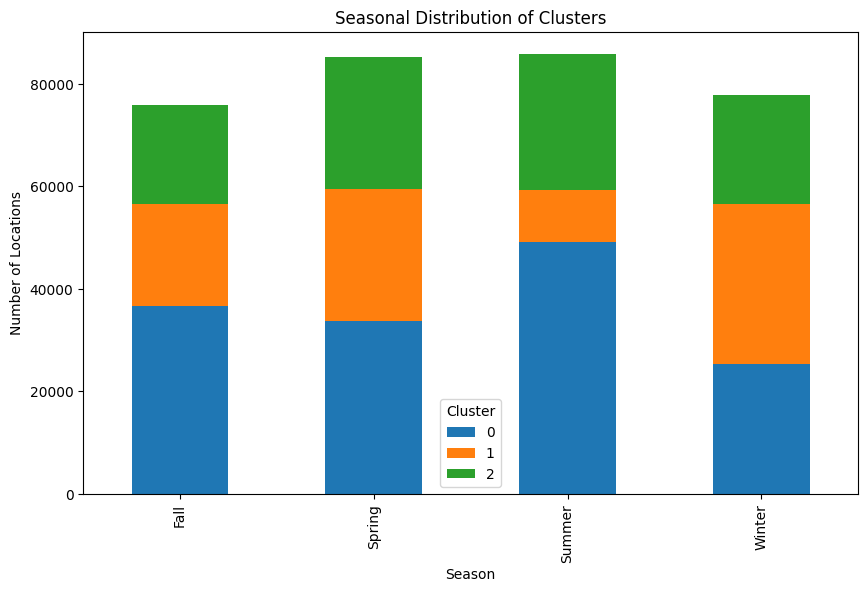

In [24]:
# Seasonal distribution of clusters
seasonal_distribution = data.groupby(['Season', 'Cluster']).size().unstack()

# Plot the seasonal distribution
seasonal_distribution.plot(kind='bar', figsize=(10, 6), stacked=True)
plt.title("Seasonal Distribution of Clusters")
plt.xlabel("Season")
plt.ylabel("Number of Locations")
plt.legend(title="Cluster")
plt.show()

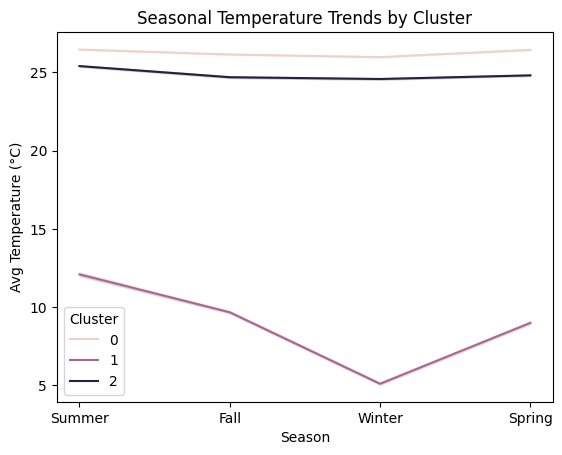

In [25]:
# Plot seasonal temperature trends by cluster
sns.lineplot(data=data.reset_index(), x='Season', y='Avg Temperature (°C)', hue='Cluster')
plt.title("Seasonal Temperature Trends by Cluster")
plt.show()

In [ ]:
!pip install keplergl

In [27]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from keplergl import KeplerGl

# Ensure the 'Cluster' column is treated as a categorical variable
data['Cluster'] = data['Cluster'].astype(str)

# Create a Kepler.gl map
kepler_map = KeplerGl(height=600)

# Add the dataset to the map with clusters as the key feature
kepler_map.add_data(data=data.reset_index(), name="Weather Clusters")

# Save the map to an HTML file for offline viewing (optional)
kepler_map.save_to_html(file_name='kepler_weather_map_clusters.html')

# Display the map
kepler_map

# Conclusions

The clustering analysis applied to the historical weather data of global capitals successfully grouped cities into three distinct clusters based on their climatic characteristics.

**Cluster Characteristics**

The three clusters revealed the following climatic zones:

*Cluster 0: Tropical/Equatorial Regions*

*   Moderate to high temperatures (26°C on average).
*   Stable climate with minimal seasonal variations.
*   Low wind speeds (9.8 m/s) and moderate atmospheric pressure (1011 hPa).
*   Geographical Coverage: found primarily in tropical regions such as South America, Central Africa, ad Southeast Asia.
*   Examples: Cities like Bangkok (Thailand), Lima (Peru), and Nairobi (Kenya).
*   Applications: suitable for year-round agricultural activities due to stable weather patterns. These regions may be more vulnerable to rising temperatures due to climate change.

*Cluster 1: Temperate/Colder Regions*

*   Lowest average temperatures (8°C) among the clusters.
*   High atmospheric pressure (1015 hPa), indicating cooler, more stable climates.
*   Moderate wind speeds (13.9 m/s), with stronger seasonal variations.
*   Geographical Coverage: found in temperate and colder regions like Northern Europe, Canada, and Russia.
*   Examples: Cities like Stockholm (Sweden), Moscow (Russia), and Ottawa (Canada).
*   Applications: understanding these regions can aid in winter energy planning and cold-weather agriculture. Seasonal variations can guide travel and tourism strategies.

*Cluster 2: Arid/Hot Regions*

*   High temperatures (~25°C on average) with minimal seasonal fluctuations.
*   Highest wind speeds (~18.2 m/s) among the clusters, indicating areas prone to strong wind currents.
*   Slightly higher atmospheric pressure (~1014 hPa), often associated with desert climates.
*   Geographical Coverage: covers arid regions such as Northern Africa (Sahara), Middle East, and Australia.
*   Examples: Cities like Riyadh (Saudi Arabia), Cairo (Egypt), and Darwin (Australia).
*   Applications: these areas could be harnessed for renewable energy, such as wind or solar power. Important for planning water resource management in dry climates.

**Practical Implications**

This analysis has several real-world applications:
Climate Adaptation: Iientifying regions most vulnerable to climate change, particularly in Clusters 0 (tropics) and 2 (arid regions).
Renewable Energy Planning: high wind speeds in Cluster 2 regions make them ideal for wind energy projects.
Agriculture: stable climates in Cluster 0 regions are suitable for year-round crops, while seasonal variations in Cluster 1 guide crop rotation.
Urban Planning: insights into climatic patterns can support infrastructure development in regions with extreme temperatures or strong winds.
